In [1]:
using Convex
using PyPlot
using ECOS
set_default_solver(ECOSSolver(verbose=0))

ECOS.ECOSSolver(Any[(:verbose, 0)])

In [2]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w; noise=0.1)
    X = randn(n,length(w))
    y = X*w + noise*randn(n)
    return X, y
end

function generate_unscaled_data(n, w; unbal_level=1000, deviation=200)
    X = [randn(n, Int(floor(length(w)/2))) deviation+unbal_level*randn(n, length(w)-Int(floor(length(w)/2)))]
    y = X*w
    return X, y
end

function generate_unscaled_noisy_data(n, w; unbal_level=1000, deviation=200)
    X = [randn(n, Int(floor(length(w)/2))) deviation+unbal_level*randn(n, length(w)-Int(floor(length(w)/2)))]
    y = X*w + .1*randn(n)
    return X, y
end 

generate_unscaled_noisy_data (generic function with 1 method)

In [3]:
d = 10
n = 20
w = randn(d)
# X, y = generate_data(n, w);

In [4]:
Xn, yn = generate_noisy_data(n, w);

Xun, yun = generate_unscaled_noisy_data(n, w);

In [5]:
# standardize
function standardize(X,y)
    X_standard = X .- mean(X,1)
    X_standard = X_standard * diagm(1./vec(std(X,1)))
    
    y_standard = y - mean(y)
    y_standard = y_standard / std(y)
    
    return X_standard, y_standard
end

# standardize only X
function standardizeX(X)
    X_standard = X .- mean(X,1)
    X_standard = X_standard * diagm(1./vec(std(X,1)))
    
#     y_standard = y - mean(y)
#     y_standard = y_standard / std(y)
    
    return X_standard
end


standardizeX (generic function with 1 method)

In [6]:
Xtest, ytest = generate_data(n, w);
Xtest_standardized, ytest_standardized = standardize(Xtest, ytest);

In [7]:
Xu_test, yu_test = generate_unscaled_data(n, w);
Xu_test_standardized, yu_test_standardized = standardize(Xu_test, yu_test);

In [8]:
function ridge_regression(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*sumsquares(w))
    solve!(p)
    return w.value
end

ridge_regression (generic function with 1 method)

In [9]:
function lasso(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*norm(w,1))
    solve!(p)
    return w.value
end

lasso (generic function with 1 method)

# Regularized Underdetermined Least Squares

In [10]:
#Try tuning λ to have a look at how results change
lasso([1 2;2 4],[3;6]; λ=500)

2×1 Array{Float64,2}:
 1.39534e-11
 1.64418e-11

In [11]:
#Try tuning λ to have a look at how results change
ridge_regression([1 2;2 4],[3;6]; λ=10)

2×1 Array{Float64,2}:
 0.428568
 0.857135

# Effect of Regularization on Variance

In [12]:
#generate several training sets using the same latent distribution
Xn1, yn1 = generate_noisy_data(n, w, noise=.5);

In [13]:
Xn2, yn2 = generate_noisy_data(n, w, noise=.5);

In [14]:
Xn3, yn3 = generate_noisy_data(n, w, noise=.5);

In [15]:
#Try tuning λ0 to have a look at how results change
λ0=500
w_ridge_1 = ridge_regression(Xn1,yn1,λ=λ0);
w_ridge_2 = ridge_regression(Xn2,yn2,λ=λ0);
w_ridge_3 = ridge_regression(Xn3,yn3,λ=λ0);

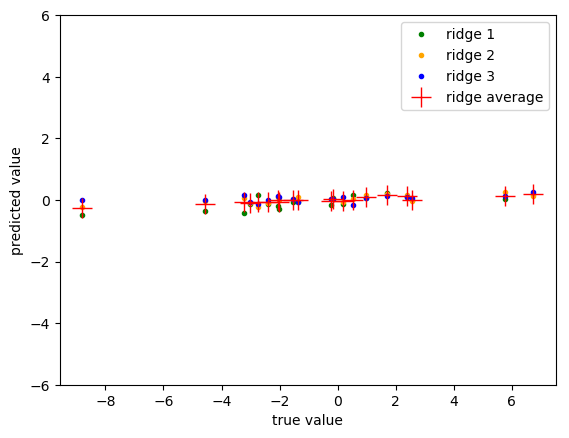

PyObject Text(24,0.5,u'predicted value')

In [16]:
#how scattered the predictions given by individual models are reflect the scale of variance
plot(ytest,Xtest*w_ridge_1,label="ridge 1",".", color="green")
plot(ytest,Xtest*w_ridge_2,label="ridge 2",".", color="orange")
plot(ytest,Xtest*w_ridge_3,label="ridge 3",".", color="blue")

plot(ytest,vec(Xtest*(w_ridge_1+w_ridge_2+w_ridge_3)./3),label="ridge average", "+", markersize=15, color="red")
legend()
ylim((-6,6))
xlabel("true value")
ylabel("predicted value")

# Effect of Regularization on Bias

In [17]:
Xn, yn = generate_noisy_data(n, w);
w_ridge_1 = ridge_regression(Xn,yn,λ=1);
w_ridge_2 = ridge_regression(Xn,yn,λ=1000);

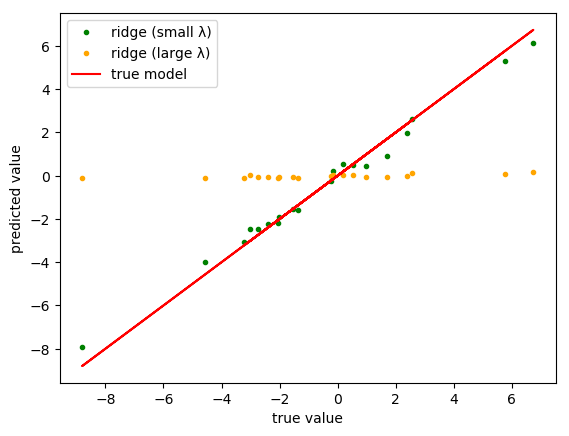

PyObject Text(24,0.5,u'predicted value')

In [18]:
plot(ytest,Xtest*w_ridge_1,label="ridge (small λ)",".", color="green")
plot(ytest,Xtest*w_ridge_2,label="ridge (large λ)",".", color="orange")

plot(ytest,ytest,label="true model", color="red")
legend()
xlabel("true value")
ylabel("predicted value")

# Standardization of Unscaled Data with Outlier

In [19]:
#make the last data point an outlier
Xun, yun = generate_unscaled_noisy_data(n+1, w);
Xun_outlier = Xun;
Xun_outlier[end,:] = 1000*Xun_outlier[end,:]+500;
yun_outlier = yun;

In [20]:
#train on data points without including outlier
w_ridge = ridge_regression(Xun[1:end-1, :],yun[1:end-1, :])

#train on data points including the outlier
w_ridge_outlier=ridge_regression(Xun_outlier,yun_outlier)

Xun_outlier_standardized, yun_outlier_standardized = standardize(Xun_outlier, yun_outlier);

#train on scaled data points including the outlier
w_ridge_outlier_standardized = ridge_regression(Xun_outlier_standardized, yun_outlier_standardized, λ=1);

In [21]:
Xu_test,yu_test = generate_unscaled_data(n,w);

Xu_test_standardized, yu_test_standardized = standardize(Xu_test, yu_test);

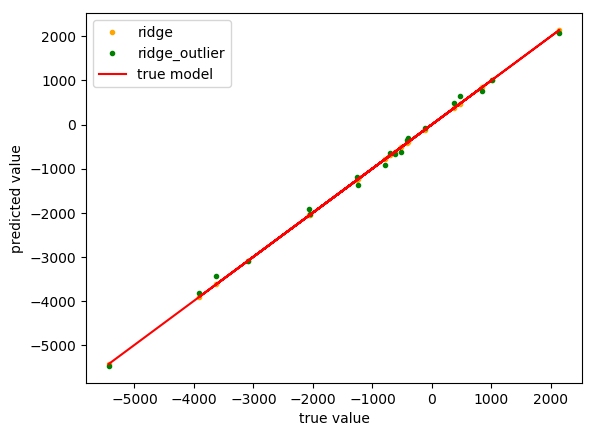

PyObject Text(24,0.5,u'predicted value')

In [22]:
#difference between predictions of models trained on datasets with or without outliers
plot(yu_test,Xu_test*w_ridge,label="ridge",".", color="orange")
plot(yu_test,Xu_test*w_ridge_outlier,label="ridge_outlier",".", color="green")

plot(yu_test,yu_test,label="true model", color="red")
legend()
xlabel("true value")
ylabel("predicted value")

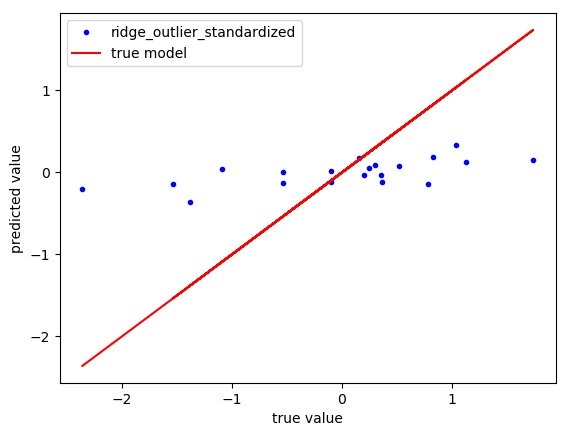

PyObject Text(24,0.5,u'predicted value')

In [23]:
#prediction accuracy of the model trained on standardized dataset with outlier
plot(yu_test_standardized,Xu_test_standardized*w_ridge_outlier_standardized,label="ridge_outlier_standardized",".", color="blue")
plot(yu_test_standardized,yu_test_standardized,label="true model", color="red")

legend()
xlabel("true value")
ylabel("predicted value")